In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os


In [2]:
mu0 = 4*np.pi*1e-7
kB = 1.380649e-23
G = 6.67430e-11
m_H = 1.6735575e-27
m_O = 2.6566962e-26
m_p = 1.6726219e-27

In [3]:
def scale_height(Texo, rexo, Mplanet, m_species):
    return kB*Texo*rexo**2/(G*Mplanet*m_species)

$H=\frac{k_B T_{exo}r^2_{exo}}{G M_p m}$


In [4]:
def jeans_escape(rexo, Texo, nexo, Mplanet, m_species):
    term = G*Mplanet*m_species/(rexo*kB*Texo)
    pref = 4*np.pi*rexo**2*np.sqrt(kB*Texo/(2*np.pi*m_species))*nexo
    return pref*(1+term)*np.exp(-term)

![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/EucwyG.png)

In [5]:
def ion_pickup(Q0_pu, rb, rexo, Texo, rexo_in, Mplanet, m_species):
    h = scale_height(Texo, rexo_in, Mplanet, m_species)
    num = (2*h**3 + 2*h**2*rb + h*rb**2)*np.exp((rexo_in - rb)/h)
    den = (2*h**3 + 2*h**2*rexo_in + h*rexo_in**2)
    return Q0_pu * (num/den)

![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/zr8pPg.png)


In [6]:
def sputtering_O(Q0_sp_O, rg, rexo, Texo_O, rexo_in, Mplanet):
    hO = scale_height(Texo_O, rexo_in, Mplanet, m_O)
    num = 1 - (2*hO**2 + 2*hO*(rexo+rg) + (rexo+rg)**2)/(2*hO**2 + 2*hO*rexo + rexo**2)*np.exp(-rg/hO)
    return Q0_sp_O * num


![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/3Wioa5.png)

In [8]:
def cross_field(Q0_cf, Omega_pc, Omega_pc_planet_today):
    return Q0_cf * (1 - Omega_pc/(4*np.pi)) / (1 - Omega_pc_planet_today/(4*np.pi))

![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/7J8sT3.png)

In [9]:
def polar_cap(Q0_pc, Omega_pc, Omega_pc_E, rexo, rexo_E):
    return Q0_pc * (Omega_pc/Omega_pc_E) * (rexo/rexo_E)**2 if Omega_pc_E and Omega_pc_E>0 else 0.0


![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/2zCH6Q.png)

In [10]:
def cusp(Q0_cu, Qmax0_cu, rc, rc_E, Omega_pc, Omega_pc_E, rexo, rexo_E):
    base = min(Q0_cu*(rc/rc_E)**2, Qmax0_cu) if (rc_E and rc_E>0) else 0.0
    return base * (Omega_pc/Omega_pc_E) * (rexo/rexo_E)**2 if (Omega_pc_E and Omega_pc_E>0) else 0.0


![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/7J8sT3.png)

In [11]:
def R_MP(mdp, nsw, vsw, f0=1.16, mi=m_p):
    rho = nsw*mi
    return (mu0*(f0**2)*mdp**2/(8*np.pi**2*rho*vsw**2))**(1/6)


![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/0GcAB8.png)


In [12]:
def Omega_pc_val(RMP, rIMB, rexo):
    if RMP >= rIMB:
        return 4*np.pi*(1 - np.sqrt(1 - rexo/RMP))
    else:
        return 0.0


![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/6JJnsQ.png)

In [62]:
planets = {
    "Venus-like": {
        "rplanet": 6051.8e3, "Mplanet": 4.867e24,
        "nsw": 1.2e7, "vsw": 4e5,
        "rexo": 6271.8e3, "rIMB": 6666.8e3, "md0": 7e18,
        "nexo_H": 1.3e9, "nexo_O": 7.5e10,
        "Texo_H": 1020.0, "Texo_O": 6400.0,
        "Q0_pc_H": 7.8e25, "Q0_pc_O": 8.0e24,
        "Q0_cu_H": 5.0e24, "Q0_cu_O": 2.0e25,
        "Q0_pu_H": 1.3e25, "Q0_pu_O": 1.2e25,
        "Q0_cf_H": 1.4e25, "Q0_cf_O": 5.2e24,
        "Q0_sp_O": 6.0e24,
        "Q0_ldr_O": 0.0, "Q0_hdr_O": 0.0,
        "Omega_pc_today": 0.0
    },
    "Earth-like": {
        "rplanet": 6371e3, "Mplanet": 5.972e24,
        "nsw": 6.0e6, "vsw": 4e5,
        "rexo": 6871e3, "rIMB": 7647e3, "md0": 7.77e22,
        "nexo_H": 8.5e10, "nexo_O": 4.0e10,
        "Texo_H": 900.0, "Texo_O": 4100.0,
        "Q0_pc_H": 7.8e25, "Q0_pc_O": 8.0e24,
        "Q0_cu_H": 5.0e24, "Q0_cu_O": 2.0e25,
        "Q0_pu_H": 5.3e26, "Q0_pu_O": 7.9e22,
        "Q0_cf_H": 7.7e25, "Q0_cf_O": 3.0e24,
        "Q0_sp_O": 6.0e24,
        "Q0_ldr_O": 0.0, "Q0_hdr_O": 0.0,
        "Omega_pc_today": 0.63
    },
    "Mars-like": {
        "rplanet": 3389.5e3, "Mplanet": 6.417e23,
        "nsw": 2.6e6, "vsw": 4e5,
        "rexo": 3609.5e3, "rIMB": 4489.5e3, "md0": 2e18,
        "nexo_H": 2.5e10, "nexo_O": 5.7e12,
        "Texo_H": 350.0, "Texo_O": 300.0,
        "Q0_pc_H": 7.8e25, "Q0_pc_O": 8.0e24,
        "Q0_cu_H": 5.0e24, "Q0_cu_O": 2.0e25,
        "Q0_pu_H": 2.3e25, "Q0_pu_O": 2.6e32,
        "Q0_cf_H": 2.0e24, "Q0_cf_O": 2.0e24,
        "Q0_sp_O": 4.5e23,
        "Q0_ldr_O": 5.0e24, "Q0_hdr_O": 5.9e25,
        "Omega_pc_today": 0.0
    }
}


In [63]:
P_E = planets["Earth-like"]
RMP_E = R_MP(P_E["md0"], P_E["nsw"], P_E["vsw"])
Omega_pc_E_ref = Omega_pc_val(RMP_E, P_E["rIMB"], P_E["rexo"])
rc_E_ref = max(RMP_E, P_E["rIMB"])
rexo_E_ref = P_E["rexo"]

# Oxygen gyroradius ~ 1 keV, 30 nT
q = 1.602176634e-19
E = 1e3*q
v_O = np.sqrt(2*E/m_O)
B_typical = 30e-9
rg_O = m_O*v_O/(q*B_typical)

md_grid = np.logspace(18, 27, 30000)
rows=[]


In [64]:
for pname, P in planets.items():
    rexo = P["rexo"]; rIMB = P["rIMB"]; Mplanet=P["Mplanet"]; Omega_pc_today=P["Omega_pc_today"]
    Q_Je_H = jeans_escape(rexo, P["Texo_H"], P["nexo_H"], Mplanet, m_H)
    Q_Je_O = jeans_escape(rexo, P["Texo_O"], P["nexo_O"], Mplanet, m_O)

    for mdp in md_grid:
        RMP = R_MP(mdp, P["nsw"], P["vsw"])
        Omega_pc = Omega_pc_val(RMP, rIMB, rexo)
        rc = rIMB if RMP < rIMB else RMP

        Q_cf_H = cross_field(P["Q0_cf_H"], Omega_pc, Omega_pc_today)
        Q_cf_O = cross_field(P["Q0_cf_O"], Omega_pc, Omega_pc_today)

        Q_pu_H = ion_pickup(P["Q0_pu_H"], rc, rexo, P["Texo_H"], rexo, Mplanet, m_H)
        Q_pu_O = ion_pickup(P["Q0_pu_O"], rc, rexo, P["Texo_O"], rexo, Mplanet, m_O)

        Q_sp_O = sputtering_O(P["Q0_sp_O"], rg_O, rexo, P["Texo_O"], rexo, Mplanet)

        Q_pc_H = polar_cap(P_E["Q0_pc_H"], Omega_pc, Omega_pc_E_ref, rexo, rexo_E_ref)
        Q_pc_O = polar_cap(P_E["Q0_pc_O"], Omega_pc, Omega_pc_E_ref, rexo, rexo_E_ref)

        Q_cu_H = cusp(P_E["Q0_cu_H"], 5e25, rc, rc_E_ref, Omega_pc, Omega_pc_E_ref, rexo, rexo_E_ref)
        Q_cu_O = cusp(P_E["Q0_cu_O"], 2e26, rc, rc_E_ref, Omega_pc, Omega_pc_E_ref, rexo, rexo_E_ref)

        Q_H = Q_Je_H + Q_cf_H + Q_pu_H + Q_pc_H + Q_cu_H
        Q_O_low = Q_Je_O + Q_cf_O + Q_pu_O + Q_pc_O + Q_cu_O + Q_sp_O + P["Q0_ldr_O"]
        Q_O_high = Q_Je_O + Q_cf_O + Q_pu_O + Q_pc_O + Q_cu_O + Q_sp_O + P["Q0_hdr_O"]

        rows.append({
            "planet": pname, "mdp_Am2": mdp, "RMP_m": RMP, "Omega_pc_sr": Omega_pc, "rc_m": rc,
            "Q_H_total_s-1": Q_H, "Q_O_total_low_s-1": Q_O_low, "Q_O_total_high_s-1": Q_O_high,
            "Mdot_low_kg_s": Q_H*m_H + Q_O_low*m_O,
            "Mdot_high_kg_s": Q_H*m_H + Q_O_high*m_O,
            "Q_Je_H": Q_Je_H, "Q_Je_O": Q_Je_O,
            "Q_cf_H": Q_cf_H, "Q_cf_O": Q_cf_O,
            "Q_pu_H": Q_pu_H, "Q_pu_O": Q_pu_O,
            "Q_pc_H": Q_pc_H, "Q_pc_O": Q_pc_O,
            "Q_cu_H": Q_cu_H, "Q_cu_O": Q_cu_O,
            "Q_sp_O": Q_sp_O
        })



In [65]:
df = pd.DataFrame(rows)
csv_path = "gunell2018_escape_model_replication_FIXED.csv"
df.to_csv(csv_path, index=False)

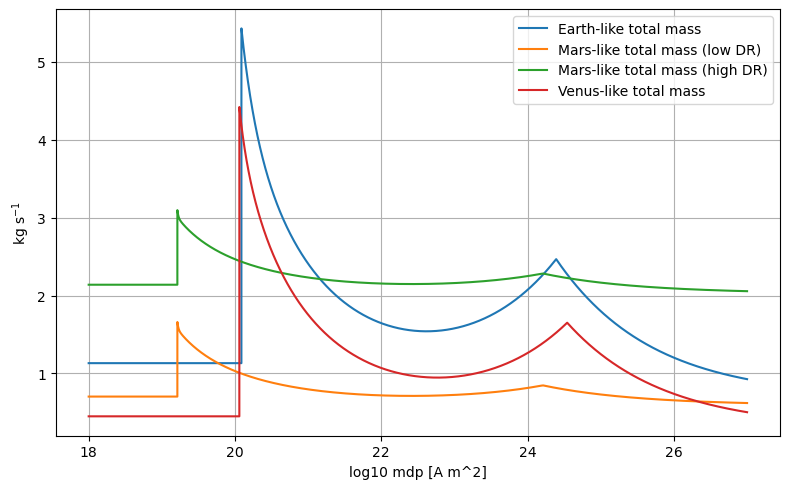

In [66]:

dfM = df[df["planet"]=="Mars-like"].copy()
dfE = df[df["planet"]=="Earth-like"].copy()
dfV = df[df["planet"]=="Venus-like"].copy()

x = np.log10(dfE["mdp_Am2"].values)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(x, dfE["Mdot_low_kg_s"], label="Earth-like total mass")
plt.plot(x, dfM["Mdot_low_kg_s"], label="Mars-like total mass (low DR)")
plt.plot(x, dfM["Mdot_high_kg_s"], label="Mars-like total mass (high DR)")

plt.plot(x, dfV["Mdot_low_kg_s"], label="Venus-like total mass")

plt.xlabel("log10 mdp [A m^2]"); plt.ylabel("kg s$^{-1}$")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


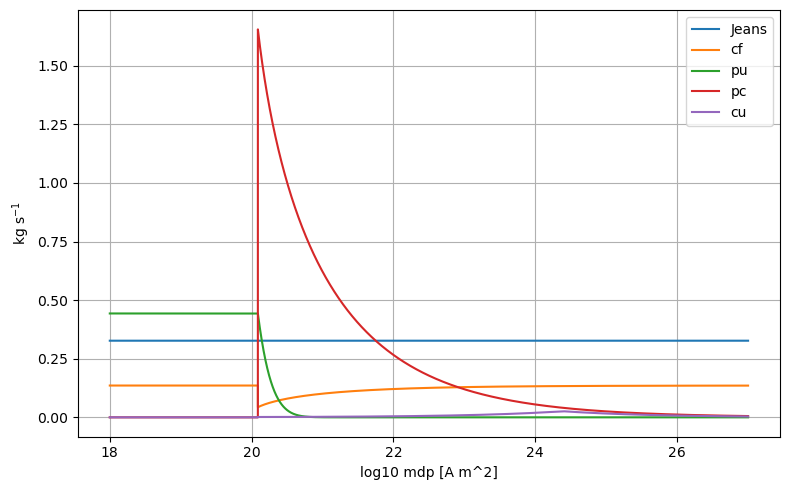

In [71]:

dfM = df[df["planet"]=="Mars-like"].copy()
dfE = df[df["planet"]=="Earth-like"].copy()
dfV = df[df["planet"]=="Venus-like"].copy()

x = np.log10(dfE["mdp_Am2"].values)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(x, dfE["Q_Je_H"]*m_H, label="Jeans")
plt.plot(x, dfE["Q_cf_H"]*m_H, label="cf")
plt.plot(x, dfE["Q_pu_H"]*m_H, label="pu")
plt.plot(x, dfE["Q_pc_H"]*m_H, label="pc")
plt.plot(x, dfE["Q_cu_H"]*m_H, label="cu")



plt.xlabel("log10 mdp [A m^2]"); plt.ylabel("kg s$^{-1}$")
# plt.yscale('log')
# plt.ylim(1e23,1e27)

plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


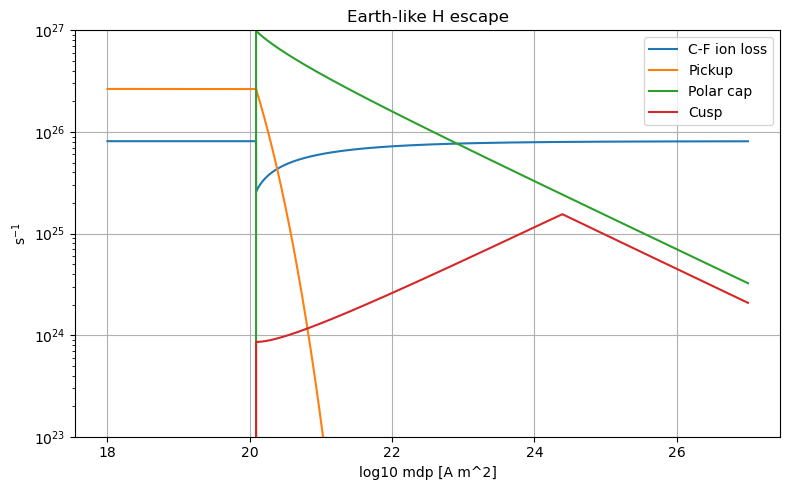

In [76]:

dfM = df[df["planet"]=="Mars-like"].copy()
dfE = df[df["planet"]=="Earth-like"].copy()
dfV = df[df["planet"]=="Venus-like"].copy()

x = np.log10(dfE["mdp_Am2"].values)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
# plt.plot(x, dfE["Q_Je_H"], label="Jeans")
plt.plot(x, dfE["Q_cf_H"], label="C-F ion loss")
plt.plot(x, dfE["Q_pu_H"], label="Pickup")
plt.plot(x, dfE["Q_pc_H"], label="Polar cap")
plt.plot(x, dfE["Q_cu_H"], label="Cusp")



plt.xlabel("log10 mdp [A m^2]"); plt.ylabel("s$^{-1}$")
plt.yscale('log')
plt.ylim(1e23,1e27)
plt.title("Earth-like H escape")

plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


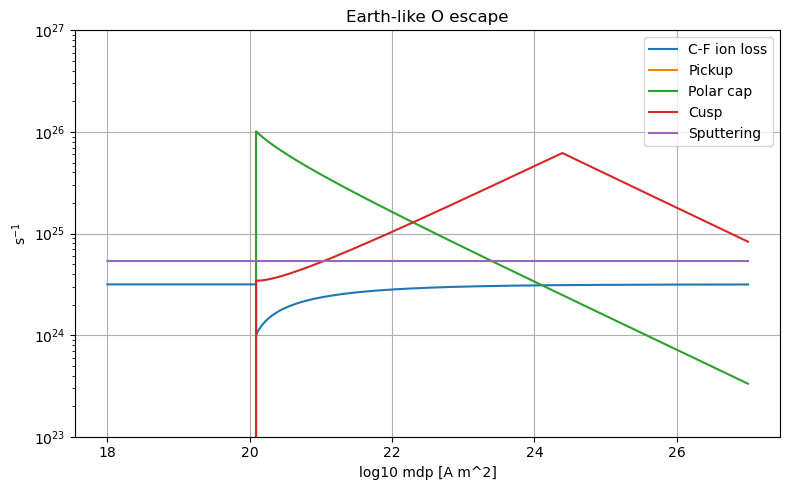

In [77]:
x = np.log10(dfE["mdp_Am2"].values)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
# plt.plot(x, dfE["Q_Je_H"], label="Jeans")
plt.plot(x, dfE["Q_cf_O"], label="C-F ion loss")
plt.plot(x, dfE["Q_pu_O"], label="Pickup")
plt.plot(x, dfE["Q_pc_O"], label="Polar cap")
plt.plot(x, dfE["Q_cu_O"], label="Cusp")
plt.plot(x, dfE["Q_sp_O"], label="Sputtering")


plt.xlabel("log10 mdp [A m^2]"); plt.ylabel("s$^{-1}$")
plt.yscale('log')
plt.ylim(1e23,1e27)
plt.title("Earth-like O escape")

plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


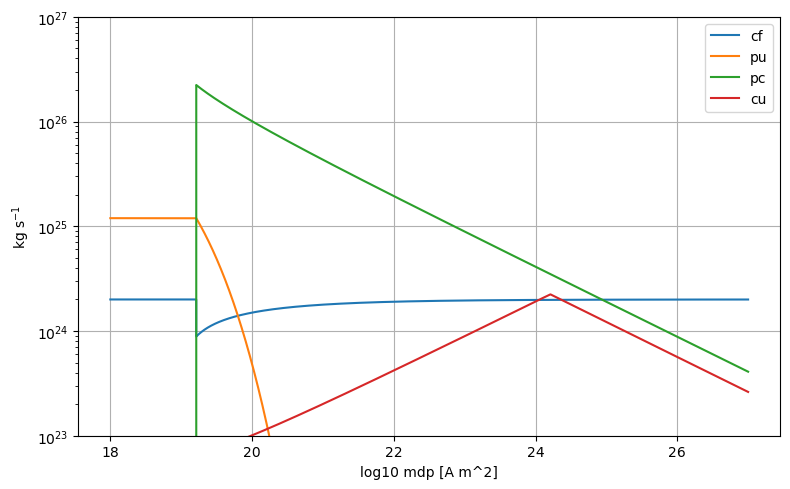

In [68]:

dfM = df[df["planet"]=="Mars-like"].copy()
dfE = df[df["planet"]=="Earth-like"].copy()
dfV = df[df["planet"]=="Venus-like"].copy()

x = np.log10(dfM["mdp_Am2"].values)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
# plt.plot(x, dfE["Q_Je_H"], label="Jeans")
plt.plot(x, dfM["Q_cf_H"], label="cf")
plt.plot(x, dfM["Q_pu_H"], label="pu")
plt.plot(x, dfM["Q_pc_H"], label="pc")
plt.plot(x, dfM["Q_cu_H"], label="cu")



plt.xlabel("log10 mdp [A m^2]"); plt.ylabel("kg s$^{-1}$")
plt.yscale('log')
plt.ylim(1e23,1e27)

plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()
